This notebook conducts a search to obtain the best form for the target values to use for a regression model with XGBoost.<br>
Scaling, log transformation, and outlier removal will be assessed to find the lowest error, before hyperparameter tuning.<br>
Once the form of the target variable values has been chosen, the results will be inspected to determine its effects.

In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from collections import defaultdict

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from matplotlib.lines import Line2D
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


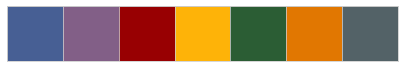

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# set option for palette argument
my_palette = ['xkcd:' + c for c in mp.my_colors]

I will begin with the unaggregated actor dataset.

In [6]:
# read in actor dataset
actor_df = pd.read_json('../data/capstone2_ref.json')

In [7]:
# observe actor by movie DataFrame before aggregation
actor_df.head()

,person_id,name,movie_id,title,revenue,budget,profit,age,gender,order,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
0,2,Mark Hamill,16121,The Big Red One,2.273880e+07,1.419948e+07,8.539315e+06,28.674100,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2,Mark Hamill,11,Star Wars,3.319102e+09,4.708566e+07,3.272016e+09,25.665140,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,Mark Hamill,14919,Batman: Mask of the Phantasm,9.944670e+06,1.062202e+07,-6.773465e+05,42.251381,0,1,...,0,0,0,0,1,0,0,1,0,0
3,2,Mark Hamill,1892,Return of the Jedi,1.490146e+09,8.417359e+07,1.405972e+09,31.663895,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2,Mark Hamill,16220,Wizards,3.930685e+07,5.240914e+06,3.406594e+07,25.377660,0,4,...,1,0,0,0,0,0,1,0,0,0


Each observation is of an actor and one of their movies.

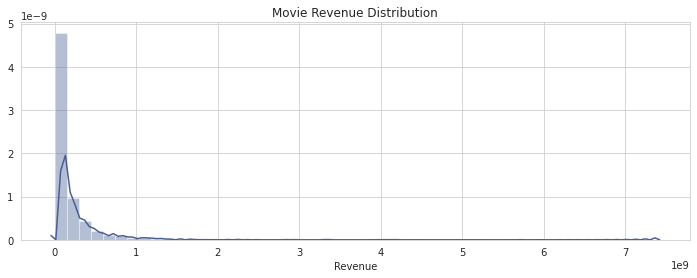

In [8]:
# plot movie revenue distribution

sns.distplot(actor_df['revenue'], color=mp.colors(0))

plt.xlabel('Revenue')

plt.title('Movie Revenue Distribution');

The distribution is quite broad.<br>
There are many outliers in the billions of dollars range.

In [9]:
# observe percentiles of unmodified movie revenues, before aggregation
actor_df['revenue'].describe()

count    4.131100e+04
mean     1.598474e+08
std      2.977362e+08
min      1.238841e+00
25%      1.705831e+07
50%      6.373003e+07
75%      1.802751e+08
max      7.377968e+09
Name: revenue, dtype: float64

The maximum movie revenue is over 7 billion dollars.<br>
Half of the movies have revenue over 60 million dollars.<br>
The average movie revenue is almost 160 million dollars.

I'll show some of the top earning movies in the dataset.

In [10]:
# get titles and revenues for movies with the top 0.5% of average revenues
actor_df[actor_df['revenue'] >= actor_df['revenue'].quantile(
    0.995)][['title', 'revenue']].drop_duplicates().sort_values(
    'revenue', ascending=False)

,title,revenue
8136,Gone with the Wind,7.377968e+09
11246,Alice in Wonderland,5.700455e+09
17006,Bambi,4.183765e+09
10746,Snow White and the Seven Dwarfs,3.361411e+09
4706,Avatar,3.332341e+09
1,Star Wars,3.319102e+09
987,Titanic,2.948799e+09
25989,Cinderella,2.895187e+09
536,Avengers: Endgame,2.825905e+09
5808,The Exorcist,2.465535e+09


This dataset spans over 100 years and is adjusted for inflation.

 > **UNMODIFIED REVENUES**

In [11]:
def aggregate_data(data, feature='person_id'):
    """Return aggregated DataFrame grouped by chosen feature"""
    # aggregate while making counts of genres and taking the average of all other values
    agg_actor_df = data.groupby(feature).agg(
        {'revenue': np.mean, 'budget': np.mean, 'age': np.mean, 'gender': 'first', 
         'order':np.mean, 'popularity':np.mean, 'release_date': np.mean, 
         'runtime': np.mean, 'usa': 'first', 'vote_average': np.mean, 
         'vote_count': np.mean, 'action': np.sum, 'adventure': np.sum, 
         'animation': np.sum, 'comedy': np.sum, 'crime': np.sum, 'drama': np.sum, 
         'family': np.sum, 'fantasy': np.sum, 'history': np.sum, 'horror': np.sum, 
         'music': np.sum, 'mystery': np.sum, 'romance': np.sum, 'science_fiction': np.sum, 
         'thriller': np.sum, 'war': np.sum, 'western': np.sum})
    
    return agg_actor_df

In [12]:
# aggregate over each actor and get DataFrame with unmodified revenues
df = aggregate_data(actor_df)
df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,1.032727e+09,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,4.376895e+08,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,7.803955e+08,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,1.147836e+09,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,1.471965e+09,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


The new dataset has been aggregated over each actor, taking the average of their movie revenues.<br>
This revenue will be the target of the predictions.

In [13]:
# separate data into features and target
X = df.drop('revenue', axis=1)
y = df['revenue']

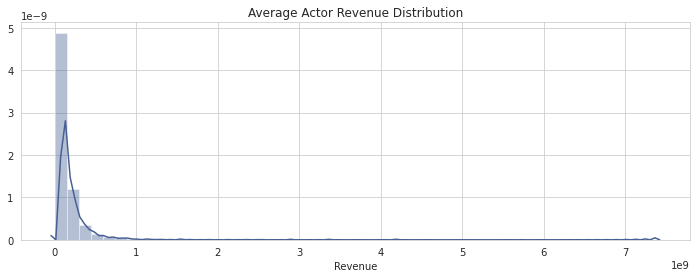

In [14]:
# plot average actor revenue distribution

sns.distplot(y, color=mp.colors(0))

plt.xlabel('Revenue')

plt.title('Average Actor Revenue Distribution');

The distribution is similar to the movie revenue distribution.

In [15]:
# observe percentiles of unmodified average actor revenues
df['revenue'].describe()

count    1.169300e+04
mean     1.386641e+08
std      2.847504e+08
min      1.238841e+00
25%      2.466701e+07
50%      7.589722e+07
75%      1.614848e+08
max      7.377968e+09
Name: revenue, dtype: float64

The maximum average actor revenue is over 7 billion dollars.<br>
Half of the actors have average revenues over 75 million dollars.<br>
The mean of the average actor revenue is almost 140 million dollars.

I'll show some of the top actors by average revenue

In [16]:
# get ids for actors with the top 0.1% of average revenues, sorted by revenue
top_actor_ids = df[df['revenue'] >= df['revenue'].quantile(0.999)].index
# get their names
top_actor_names = actor_df[actor_df['person_id'].isin(top_actor_ids)]['name'].unique()
# get their average revenues
top_actor_revenues = df[df.index.isin(top_actor_ids)]['revenue']
# create DataFrame with names and revenues
pd.DataFrame(list(zip(
    top_actor_names, 
    top_actor_revenues)), columns=['name', 'average_revenue']).sort_values(
    'average_revenue', ascending=False)

,name,average_revenue
0,Barbara O'Neil,7.377968e+09
1,Leslie Howard,7.377968e+09
2,Evelyn Keyes,7.377968e+09
3,Ann Rutherford,7.377968e+09
4,Hattie McDaniel,7.377968e+09
12,Jerry Colonna,5.700455e+09
5,Cammie King,4.183765e+09
6,Donnie Dunagan,4.183765e+09
7,Hardie Albright,4.183765e+09
8,Sam Edwards,4.183765e+09


These are not the actors usually listed among the top earners.<br>
The first 5 are from Gone With The Wind.<br>
The rest are from 2 Disney movies.<br>
Average actor revenues can be deceptively high, when there is only one film in consideration.

In [17]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

First, I will be observing the effects on model errors by modifying the actor average movie revenues.<br>
Then, I will modify the movie revenues, directly and before aggregation, for comparison.

I will be performing numeric transformations, such as taking the natural log and scaling.<br>
I will build a cross validation function from scratch to get the model errors.<br>
This is necessary to retain the transformed predictions for calculating the errors, using the transformed test data.<br>
After I have the errors from the model, I will transform them to dollar amounts for interpretation.

In [18]:
def scratch_cv(features, target, log, scaled, scaled_df):
    """Return average mean absolute error from each 10 fold cross validation result"""
    # create empty list to hold MAE from each fold
    mae_lst = []    
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)
    # split data into 10 folds
    for train_index, test_index in folds.split(features, target):
        train_features = features.iloc[train_index]
        train_target = target.iloc[train_index]
        test_features = features.iloc[test_index]
        test_target = target.iloc[test_index]
        # instantiate and fit model
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=27, 
                                 n_jobs=-1).fit(train_features, train_target)
        # get predictions
        y_pred = model.predict(test_features)
        # ensure returned errors are interpretable
        if log:
            # convert data from log dollars to dollars
            test_target = np.exp(test_target)
            y_pred = np.exp(y_pred)
        if scaled:
            # get column that was scaled
            y = scaled_df['revenue']
            # convert data from scaled dollars to dollars
            test_target = np.multiply(test_target, np.std(y)) + np.mean(y)
            y_pred = np.multiply(y_pred, np.std(y)) + np.mean(y)
        # calculate MAE for each fold and save results to list
        errors = np.absolute(y_pred - test_target)
        mae = np.mean(errors)
        mae_lst.append(mae)
        
    return mae_lst

In [19]:
def make_money(number):
    """Return dollar formatted string"""
    dollar = '${:,.2f}'.format(number)
    
    return dollar

In [20]:
# create default dict to store results of every form tried for representing revenue
revenue_dict = defaultdict(list)

def get_cv_mae(
    name, features, target, log=False, scaled=False, scaled_df=pd.DataFrame()):
    """Print average mean absolute error and error range from 10 fold cross validation"""
    # get average result from each CV fold
    mae_lst = scratch_cv(features, target, log, scaled, scaled_df)
    # get overall average MAE of the 10 folds
    average_mae = np.mean(mae_lst)
    # get MAE range over all 10 folds
    mae_range = (np.min(mae_lst), np.max(mae_lst))
    # store results for final comparison
    revenue_dict[name].append('{}'.format(make_money(average_mae)))
        
    print(name, '\nAverage MAE: {}       CV Range: ({}, {})'.format(
        make_money(average_mae), make_money(mae_range[0]), make_money(mae_range[1])))

In [21]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Original Revenues', X_train, y_train)

Original Revenues 
Average MAE: $56,799,637.33       CV Range: ($53,295,022.62, $58,574,028.26)


This is the base error that I will minimize through modifying the target.

 > **SCALED ACTOR REVENUE**

Now, I will perform scaling on the revenue values that were aggregated over each actor.

In [22]:
def scale_revenue(data):
    """Returns DataFrame with scaled revenue"""
    # get statistics of dataset used for scaling
    mean = np.mean(data['revenue'])
    std = np.std(data['revenue'])
    # create copy of dataset to return
    copy_df = data.copy()
    # apply scaling to dataset copy
    copy_df['revenue'] =  (copy_df['revenue'] - mean) / std
    
    return copy_df

In [23]:
# aggregate over each actor and get DataFrame with scaled actor revenue
scaled_df = scale_revenue(aggregate_data(actor_df))
scaled_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,3.139947,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,1.050176,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,2.253759,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,3.544210,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,4.682549,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [24]:
# separate training data into features and target
scaled_X = scaled_df.drop('revenue', axis=1)
scaled_y = scaled_df['revenue']

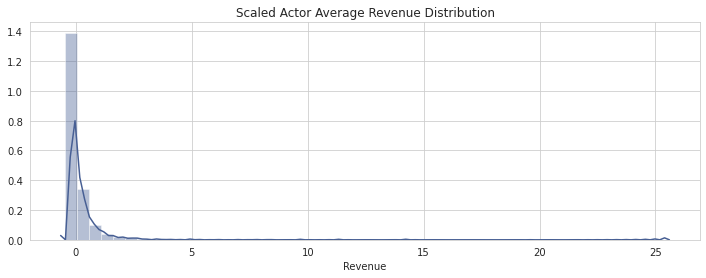

In [25]:
# plot target distribution

sns.distplot(scaled_y, color=mp.colors(0))

plt.xlabel('Revenue')

plt.title('Scaled Actor Average Revenue Distribution');

While the scale has been reduced, the outliers remain.<br>
The shape of the distribution is the same.

In [26]:
# split dataset
scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = train_test_split(
    scaled_X, scaled_y, test_size=0.2, random_state=27)

In [27]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Scaled Revenues', scaled_X_train, scaled_y_train, scaled=True, scaled_df=df)

Scaled Revenues 
Average MAE: $56,914,594.28       CV Range: ($53,065,142.69, $59,283,239.38)


The improvement is marginal, after scaling the actor average revenue.

 > **LOG ACTOR REVENUE**

Now, I will observed the results of taking the natural log of the aggregated revenues.

In [28]:
def get_log_revenue(data):
    """Returns DataFrame with log of revenue"""
    # create copy of dataset to return
    copy_df = data.copy()
    # take log of dataset copy
    copy_df['revenue'] = np.log(copy_df['revenue'])
    
    return copy_df

In [29]:
# aggregate over each actor and get DataFrame with log actor revenue
log_df = get_log_revenue(aggregate_data(actor_df))
log_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,20.755469,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,19.897020,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,20.475311,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,20.861144,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,21.109864,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [30]:
# separate training data into features and target
log_X = log_df.drop('revenue', axis=1)
log_y = log_df['revenue']

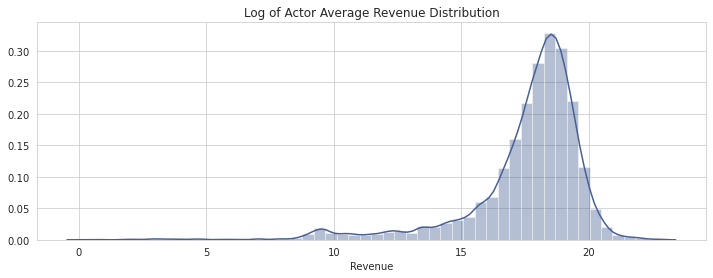

In [31]:
# plot target distribution

sns.distplot(log_y, color=mp.colors(0))

plt.xlabel('Revenue')

plt.title('Log of Actor Average Revenue Distribution');

The skew of the distribution has been reflected to the lower values.<br>
The distribution does not appear normal.

In [32]:
# split dataset
log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(
    log_X, log_y, test_size=0.2, random_state=27)

In [33]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Log Revenues', log_X_train, log_y_train, log=True)

Log Revenues 
Average MAE: $59,562,756.22       CV Range: ($53,284,314.02, $69,808,156.21)


The errors are larger than those of the base model.<br>
Taking the log of the actor average revenue is counterproductive.

 > **NO OUTLIERS ACTOR REVENUE**

I will remove the outlier revenues, after aggregating the datset by actor.<br>
An outlier is defined as lying greater than three standard deviations from the mean of the revenue distribution.

In [34]:
def remove_outliers(data, before_agg=False):
    """Return DataFrame after outliers have been identified and removed"""
    # create copy of dataset to identify outlier revenues
    copy_df = data.copy()
    # aggregate over movies, if data has not been aggregated over actors
    if before_agg:
        copy_df = aggregate_data(copy_df, feature='movie_id')
    # determine outlier cut off values
    mean = np.mean(copy_df['revenue'])
    std = np.std(copy_df['revenue'])
    cut_off = std * 3
    # define lower and upper bounds for outliers
    lower, upper = mean - cut_off, mean + cut_off
    # remove outlier revenues from dataset
    new_df = data[(data['revenue'] < upper) & (data['revenue'] > lower)]
    
    return new_df

In [35]:
# aggregate over each actor and get DataFrame with no outliers actor revenue
no_df = remove_outliers(aggregate_data(actor_df))
no_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
3,4.376895e+08,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,7.803955e+08,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
10,8.530622e+08,1.892706e+08,44.571757,0,4.500000,37.201500,2005.000000,94.000000,1,7.850000,...,0,0,0,0,0,0,0,0,0,0
12,7.067063e+08,9.858666e+07,10.421843,0,4.000000,22.071500,2004.500000,93.500000,1,6.950000,...,0,0,0,0,0,0,0,0,0,0
13,4.196991e+08,6.813673e+07,55.390099,0,3.000000,17.325636,2002.363636,108.181818,1,7.018182,...,1,0,1,0,0,2,1,3,0,0


In [36]:
# separate training data into features and target
no_X = no_df.drop('revenue', axis=1)
no_y = no_df['revenue']

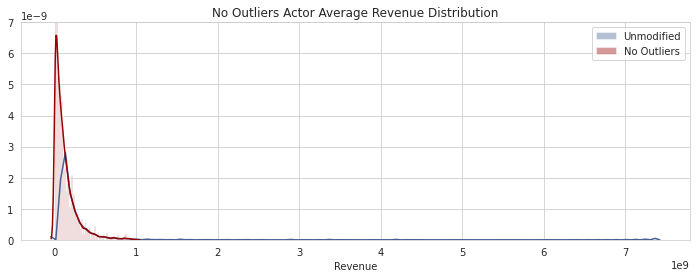

In [37]:
# plot target distributions

plt.ylim(top=7e-9)

sns.distplot(y, color=mp.colors(0), label='Unmodified', bins=500)
sns.distplot(no_y, color=mp.colors(2), label='No Outliers', bins=500)

plt.xlabel('Revenue')

plt.legend()
plt.title('No Outliers Actor Average Revenue Distribution');

The distribution is, now, shifted to lower values.

In [38]:
# split dataset
no_X_train, no_X_test, no_y_train, no_y_test = train_test_split(
    no_X, no_y, test_size=0.2, random_state=27)

In [39]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('No Outliers Revenues', no_X_train, no_y_train)

No Outliers Revenues 
Average MAE: $48,136,510.36       CV Range: ($43,905,831.29, $51,049,659.37)


The average error has been reduced by about 15%, after removing the outliers from the average actor revenue.

 > **NO OUTLIERS SCALED ACTOR REVENUE**

Now, I will combine two of the previous data manipulations, in succession.<br>
First, I will scale the aggregated data, then remove the scaled outliers.

In [40]:
# aggregate over each actor and get DataFrame with no outliers of scaled actor revenue
no_scaled_df = remove_outliers(scale_revenue(aggregate_data(actor_df)))
no_scaled_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
3,1.050176,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,2.253759,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
10,2.508964,1.892706e+08,44.571757,0,4.500000,37.201500,2005.000000,94.000000,1,7.850000,...,0,0,0,0,0,0,0,0,0,0
12,1.994963,9.858666e+07,10.421843,0,4.000000,22.071500,2004.500000,93.500000,1,6.950000,...,0,0,0,0,0,0,0,0,0,0
13,0.986994,6.813673e+07,55.390099,0,3.000000,17.325636,2002.363636,108.181818,1,7.018182,...,1,0,1,0,0,2,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,-0.486858,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,-0.485719,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,-0.485719,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [41]:
# separate training data into features and target
no_scaled_X = no_scaled_df.drop('revenue', axis=1)
no_scaled_y = no_scaled_df['revenue']

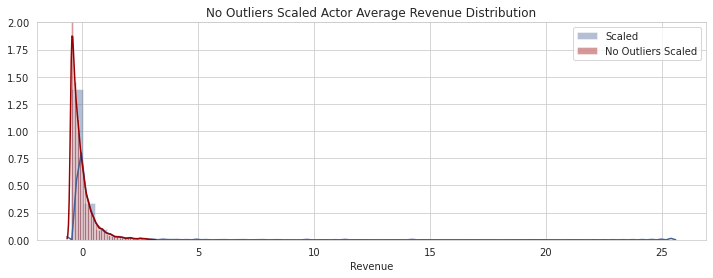

In [42]:
# plot target distributions
plt.ylim(top=2)

sns.distplot(scaled_y, color=mp.colors(0), label='Scaled')
sns.distplot(no_scaled_y, color=mp.colors(2), label='No Outliers Scaled')

plt.xlabel('Revenue')

plt.legend()
plt.title('No Outliers Scaled Actor Average Revenue Distribution');

The scale of the data is reduced by a factor of 10, and there is no outlier mode in the high values.

In [43]:
# split dataset
no_scaled_X_train, no_scaled_X_test, \
no_scaled_y_train, no_scaled_y_test = train_test_split(
    no_scaled_X, no_scaled_y, test_size=0.2, random_state=27)

In [44]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('No Outliers Scaled Revenues', no_scaled_X_train, no_scaled_y_train, 
           scaled=True, scaled_df=df)

No Outliers Scaled Revenues 
Average MAE: $48,271,338.54       CV Range: ($43,380,962.38, $51,034,797.72)


The results are slightly worse than simply using the unscaled data to identify outliers.

 > **LOG NO OUTLIERS ACTOR REVENUE**

The last modification of the aggregated data I will perform is taking the log of the revenue, after removing outliers.

In [45]:
# aggregate over each actor and get DataFrame with log of no outliers actor revenue
log_no_df = get_log_revenue(remove_outliers(aggregate_data(actor_df)))
log_no_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
3,19.897020,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,20.475311,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
10,20.564343,1.892706e+08,44.571757,0,4.500000,37.201500,2005.000000,94.000000,1,7.850000,...,0,0,0,0,0,0,0,0,0,0
12,20.376126,9.858666e+07,10.421843,0,4.000000,22.071500,2004.500000,93.500000,1,6.950000,...,0,0,0,0,0,0,0,0,0,0
13,19.855049,6.813673e+07,55.390099,0,3.000000,17.325636,2002.363636,108.181818,1,7.018182,...,1,0,1,0,0,2,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,10.515550,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,12.797395,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,12.797395,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [46]:
# separate training data into features and target
log_no_X = log_no_df.drop('revenue', axis=1)
log_no_y = log_no_df['revenue']

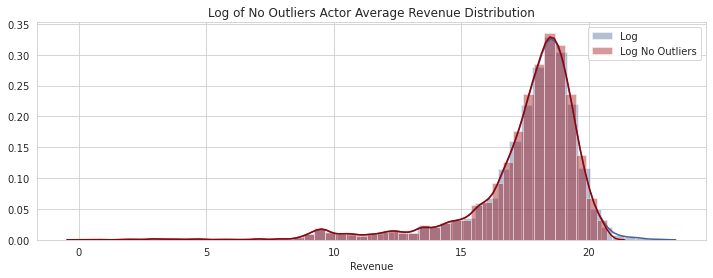

In [47]:
# plot target distributions

sns.distplot(log_y, color=mp.colors(0), label='Log')
sns.distplot(log_no_y, color=mp.colors(2), label='Log No Outliers')

plt.xlabel('Revenue')

plt.legend()
plt.title('Log of No Outliers Actor Average Revenue Distribution');

The distributions are very similar.<br>
The large values show the sharp drop off that results from eliminating the outliers.

In [48]:
# split dataset
log_no_X_train, log_no_X_test, \
log_no_y_train, log_no_y_test = train_test_split(
    log_no_X, log_no_y, test_size=0.2, random_state=27)

In [49]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Log No Outliers Revenues', log_no_X_train, log_no_y_train, log=True)

Log No Outliers Revenues 
Average MAE: $47,865,232.74       CV Range: ($40,638,096.22, $51,172,942.26)


The errors are minimized slightly better with this representation of the actor average revenues.

I will now turn to modifying the movie revenues, before they are aggregated by actor.<br>
I would like to know if this results in data that can be better utilized by the models for making predictions.

 > **MODIFY REVENUE BEFORE AGGREGATION**

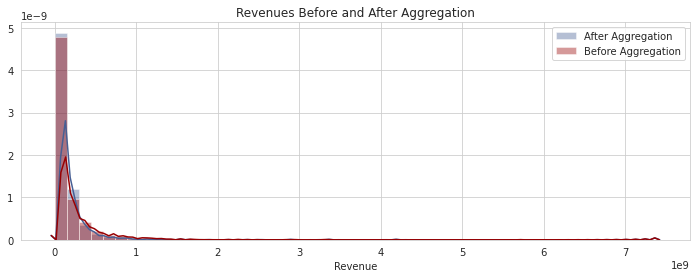

In [50]:
# plot target distributions

sns.distplot(y, color=mp.colors(0), label='After Aggregation')
sns.distplot(actor_df['revenue'], color=mp.colors(2), label='Before Aggregation')

plt.xlabel('Revenue')

plt.legend()
plt.title('Revenues Before and After Aggregation');

The aggregation has shifted the distribution of revenues toward lower values.

In [51]:
# observe statistical differences between distributions
print('Percent Differences of Dataset Percentiles After Aggregation:')
# specify percentiles to calculate
percentiles = [0.1, 0.5, 0.9]
# get percent differences
(y.describe(
    percentiles) - actor_df['revenue'].describe(
    percentiles)) / actor_df['revenue'].describe(
    percentiles) * 100

Percent Differences of Dataset Percentiles After Aggregation:


count   -71.695190
mean    -13.252189
std      -4.361509
min       0.000000
10%      56.911596
50%      19.091766
90%     -27.138356
max       0.000000
Name: revenue, dtype: float64

As expected, there are less observations for revenues after aggregation.<br>
The mean of the revenues is smaller after the aggregation.<br>
The median of the revenues is larger after the aggregation.<br>
The revenues are more heavily distributed to the lower percentiles after aggregation.

Note that because the revenues before aggregation are for individual movies, I will name the DataFrames using "movies".<br>
The resulting datasets will still be aggreagated over the actors, but only after the revenues have been modified.

 > **SCALED REVENUE BEFORE AGGREGATION**

Here, I will scale the movie revenues, then aggregate the data by actor.

In [52]:
# get DataFrame with scaled movies revenue, then aggregate over each actor
scaled_movies_df = aggregate_data(scale_revenue(actor_df))
scaled_movies_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,2.931757,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,0.933193,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,2.084246,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,3.318376,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,4.407034,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [53]:
# separate training data into features and target
scaled_movies_X = scaled_movies_df.drop('revenue', axis=1)
scaled_movies_y = scaled_movies_df['revenue']

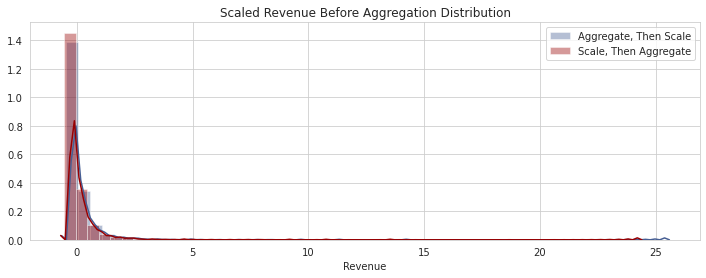

In [54]:
# plot target distributions

sns.distplot(scaled_y, color=mp.colors(0), label='Aggregate, Then Scale')
sns.distplot(scaled_movies_y, color=mp.colors(2), label='Scale, Then Aggregate')

plt.xlabel('Revenue')

plt.legend()
plt.title('Scaled Revenue Before Aggregation Distribution');

The distribution appears similar to the one where the data was aggregated before scaling.

In [55]:
# split dataset
scaled_movies_X_train, scaled_movies_X_test, \
scaled_movies_y_train, scaled_movies_y_test = train_test_split(
    scaled_movies_X, scaled_movies_y, test_size=0.2, random_state=27)

In [56]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Scaled Revenues', scaled_movies_X_train, scaled_movies_y_train, 
           scaled=True, scaled_df=actor_df)

Scaled Revenues 
Average MAE: $56,971,631.61       CV Range: ($53,496,937.72, $59,287,931.39)


The errors are not very different from those obtained through scaling after data aggregation.<br>
The average error is still slightly worse than that found by using the unmodified revenues.

 > **LOG REVENUE BEFORE AGGREGATION**

Now, I will apply the log transform, before data aggregation.

In [57]:
# get DataFrame with log movies revenue, then aggregate over each actor
log_movies_df = aggregate_data(get_log_revenue(actor_df))
log_movies_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,19.188312,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,18.885104,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,18.370769,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,19.260451,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,20.752725,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [58]:
# separate training data into features and target
log_movies_X = log_movies_df.drop('revenue', axis=1)
log_movies_y = log_movies_df['revenue']

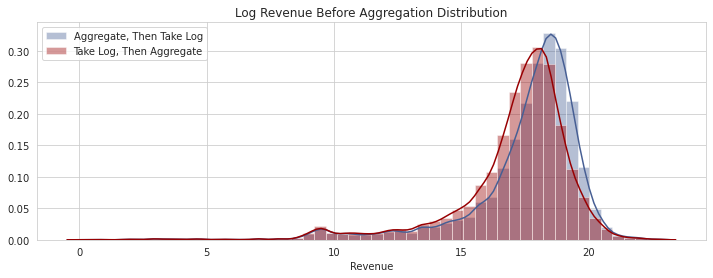

In [59]:
# plot target distributions

sns.distplot(log_y, color=mp.colors(0), label='Aggregate, Then Take Log')
sns.distplot(log_movies_y, color=mp.colors(2), label='Take Log, Then Aggregate')

plt.xlabel('Revenue')

plt.legend(loc=2)
plt.title('Log Revenue Before Aggregation Distribution');

The shift to lower values is easier to observe with the log data.

In [60]:
# split dataset
log_movies_X_train, log_movies_X_test, \
log_movies_y_train, log_movies_y_test = train_test_split(
    log_movies_X, log_movies_y, test_size=0.2, random_state=27)

In [61]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Log Revenues', log_movies_X_train, log_movies_y_train, log=True)

Log Revenues 
Average MAE: $53,194,579.23       CV Range: ($46,776,841.69, $61,359,167.12)


Unlike taking the log after aggregation, the average error has improved, slightly.

 > **NO OUTLIERS REVENUE BEFORE AGGREGATION**

Now I will observe the effect of removing the outliers, before aggregation.

In [62]:
# get DataFrame with no outliers revenue, then aggregate over each actor
no_movies_df = aggregate_data(remove_outliers(actor_df, before_agg=True))
no_movies_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,2.425752e+07,8.778750e+06,45.773425,0,1.400000,13.497800,1997.000000,86.200000,1,6.620000,...,1,0,1,0,1,0,1,1,1,0
3,2.299171e+08,8.345003e+07,56.479322,0,0.783784,22.042243,1998.540541,118.027027,1,6.562162,...,1,1,1,0,5,9,4,17,2,2
4,5.191338e+07,2.402895e+07,38.717047,1,4.000000,8.555667,1995.111111,102.000000,1,6.044444,...,1,0,1,1,0,4,0,1,0,0
5,6.220332e+07,1.244080e+07,57.560388,0,1.000000,10.428500,1970.500000,86.000000,0,7.000000,...,0,0,1,0,0,0,1,0,0,0
6,1.166933e+08,1.531840e+07,32.731678,0,8.000000,11.983000,1978.000000,132.000000,0,6.500000,...,1,0,0,0,0,0,0,0,0,0


In [63]:
# separate training data into features and target
no_movies_X = no_movies_df.drop('revenue', axis=1)
no_movies_y = no_movies_df['revenue']

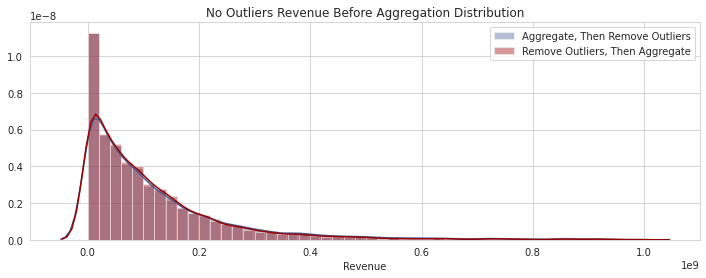

In [64]:
# plot target distributions

sns.distplot(no_y, color=mp.colors(0), label='Aggregate, Then Remove Outliers')
sns.distplot(no_movies_y, color=mp.colors(2), label='Remove Outliers, Then Aggregate')

plt.xlabel('Revenue')

plt.legend()
plt.title('No Outliers Revenue Before Aggregation Distribution');

The two distibutions closely overlap.

In [65]:
# split dataset
no_movies_X_train, no_movies_X_test, \
no_movies_y_train, no_movies_y_test = train_test_split(
    no_movies_X, no_movies_y, test_size=0.2, random_state=27)

In [66]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('No Outliers Revenues', no_movies_X_train, no_movies_y_train)

No Outliers Revenues 
Average MAE: $45,296,500.10       CV Range: ($41,594,757.40, $48,397,581.17)


Removing outliers before aggergation has improved the predictions, even more.

 > **NO OUTLIERS SCALED REVENUE BEFORE AGGREGATION**

Now, I will scale, remove outliers, and aggregate the data, in that order.

In [67]:
# get DataFrame with no outliers of scaled movies revenue, then aggregate over each actor
no_scaled_movies_df = aggregate_data(
    remove_outliers(scale_revenue(actor_df), before_agg=True))
no_scaled_movies_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,-0.455408,8.778750e+06,45.773425,0,1.400000,13.497800,1997.000000,86.200000,1,6.620000,...,1,0,1,0,1,0,1,1,1,0
3,0.235344,8.345003e+07,56.479322,0,0.783784,22.042243,1998.540541,118.027027,1,6.562162,...,1,1,1,0,5,9,4,17,2,2
4,-0.362520,2.402895e+07,38.717047,1,4.000000,8.555667,1995.111111,102.000000,1,6.044444,...,1,0,1,1,0,4,0,1,0,0
5,-0.327959,1.244080e+07,57.560388,0,1.000000,10.428500,1970.500000,86.000000,0,7.000000,...,0,0,1,0,0,0,1,0,0,0
6,-0.144942,1.531840e+07,32.731678,0,8.000000,11.983000,1978.000000,132.000000,0,6.500000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,-0.536759,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,-0.535669,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,-0.535669,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [68]:
# separate training data into features and target
no_scaled_movies_X = no_scaled_movies_df.drop('revenue', axis=1)
no_scaled_movies_y = no_scaled_movies_df['revenue']

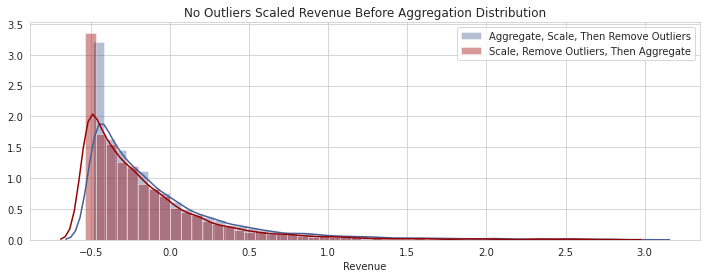

In [69]:
# plot target distributions

sns.distplot(no_scaled_y, color=mp.colors(0), 
             label='Aggregate, Scale, Then Remove Outliers')
sns.distplot(no_scaled_movies_y, color=mp.colors(2), 
             label='Scale, Remove Outliers, Then Aggregate')

plt.xlabel('Revenue')

plt.legend()
plt.title('No Outliers Scaled Revenue Before Aggregation Distribution');

The distribution has been shifted to lower values.

In [70]:
# split dataset
no_scaled_movies_X_train, no_scaled_movies_X_test, \
no_scaled_movies_y_train, no_scaled_movies_y_test = train_test_split(
    no_scaled_movies_X, no_scaled_movies_y, test_size=0.2, random_state=27)

In [71]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('No Outliers Scaled Revenues', 
           no_scaled_movies_X_train, no_scaled_movies_y_train, 
           scaled=True, scaled_df=actor_df)

No Outliers Scaled Revenues 
Average MAE: $45,334,447.47       CV Range: ($41,755,745.92, $48,369,214.76)


The average error has been improved, even more, when aggregating after modifications.

 > **LOG NO OUTLIERS REVENUE BEFORE AGGREGATION**

Finally, I will remove outliers, take the log, then aggregate the dataset.

In [72]:
# get DataFrame with log of no outliers movies revenue, then aggregate over each actor
log_no_movies_df = aggregate_data(
    get_log_revenue(remove_outliers(actor_df, before_agg=True)))
log_no_movies_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,16.676154,8.778750e+06,45.773425,0,1.400000,13.497800,1997.000000,86.200000,1,6.620000,...,1,0,1,0,1,0,1,1,1,0
3,18.554333,8.345003e+07,56.479322,0,0.783784,22.042243,1998.540541,118.027027,1,6.562162,...,1,1,1,0,5,9,4,17,2,2
4,16.430098,2.402895e+07,38.717047,1,4.000000,8.555667,1995.111111,102.000000,1,6.044444,...,1,0,1,1,0,4,0,1,0,0
5,17.929196,1.244080e+07,57.560388,0,1.000000,10.428500,1970.500000,86.000000,0,7.000000,...,0,0,1,0,0,0,1,0,0,0
6,18.575060,1.531840e+07,32.731678,0,8.000000,11.983000,1978.000000,132.000000,0,6.500000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,10.515550,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,12.797395,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,12.797395,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [73]:
# separate training data into features and target
log_no_movies_X = log_no_movies_df.drop('revenue', axis=1)
log_no_movies_y = log_no_movies_df['revenue']

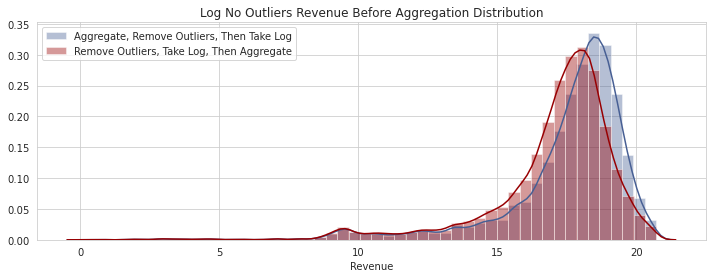

In [74]:
# plot target distributions

sns.distplot(log_no_y, color=mp.colors(0), 
             label='Aggregate, Remove Outliers, Then Take Log')
sns.distplot(log_no_movies_y, color=mp.colors(2), 
             label='Remove Outliers, Take Log, Then Aggregate')

plt.xlabel('Revenue')

plt.legend()
plt.title('Log No Outliers Revenue Before Aggregation Distribution');

The data is shifted to lower values, again.

In [75]:
# split dataset
log_no_movies_X_train, log_no_movies_X_test, \
log_no_movies_y_train, log_no_movies_y_test = train_test_split(
    log_no_movies_X, log_no_movies_y, test_size=0.2, random_state=27)

In [76]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Log No Outliers Revenues', log_no_movies_X_train, log_no_movies_y_train, 
           log=True)

Log No Outliers Revenues 
Average MAE: $41,215,414.04       CV Range: ($37,715,726.10, $44,835,561.81)


This technique has produced the best results.<br>
The average error has been reduced by 27%.

 > **MODIFIED REVENUES SUMMARY**

Here are the data manipulation results.

In [77]:
# organize and display results
for key, val in revenue_dict.items():
    print(key)
    if len(val) == 2:
        print('Aggregate First: ', val[0], '    Aggregate Last: ', val[1], '\n')
    else:
        print(val[0], '\n')

Original Revenues
$56,799,637.33 

Scaled Revenues
Aggregate First:  $56,914,594.28     Aggregate Last:  $56,971,631.61 

Log Revenues
Aggregate First:  $59,562,756.22     Aggregate Last:  $53,194,579.23 

No Outliers Revenues
Aggregate First:  $48,136,510.36     Aggregate Last:  $45,296,500.10 

No Outliers Scaled Revenues
Aggregate First:  $48,271,338.54     Aggregate Last:  $45,334,447.47 

Log No Outliers Revenues
Aggregate First:  $47,865,232.74     Aggregate Last:  $41,215,414.04 



Aggregating as the last step consistantly gives better results.<br>
The best technique is to remove outliers, take the log, then aggregate.<br>
I will use this method going forward.

Now, I can store the datasets for further use in notebooks, downstream.

In [78]:
# store aggregated modified dataset in JSON to use by models
log_no_movies_df.to_json('../data/capstone2_optimized_target_ds.json')

I will create a DataFrame that has the outlier movies removed, but remains unaggregated to use for model interpretation.

In [79]:
# get DataFrame with no outliers movies revenue
actor_no_movies_df = remove_outliers(actor_df, before_agg=True)
actor_no_movies_df.head(8)

,person_id,name,movie_id,title,revenue,budget,profit,age,gender,order,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
0,2,Mark Hamill,16121,The Big Red One,2.273880e+07,1.419948e+07,8.539315e+06,28.674100,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2,Mark Hamill,14919,Batman: Mask of the Phantasm,9.944670e+06,1.062202e+07,-6.773465e+05,42.251381,0,1,...,0,0,0,0,1,0,0,1,0,0
4,2,Mark Hamill,16220,Wizards,3.930685e+07,5.240914e+06,3.406594e+07,25.377660,0,4,...,1,0,0,0,0,0,1,0,0,0
9,2,Mark Hamill,533642,Child's Play,4.524793e+07,1.007699e+07,3.517094e+07,67.733081,0,0,...,0,0,1,0,0,0,0,0,0,0
10,2,Mark Hamill,382322,Batman: The Killing Joke,4.049338e+06,3.754353e+06,2.949849e+05,64.830900,0,1,...,0,0,0,0,0,0,0,0,0,0
11,3,Harrison Ford,2655,What Lies Beneath,4.353007e+08,1.493721e+08,2.859286e+08,58.024463,0,0,...,0,0,1,0,1,0,0,1,0,0
12,3,Harrison Ford,27569,Extraordinary Measures,1.802779e+07,3.692683e+07,-1.889904e+07,67.527738,0,0,...,0,0,0,0,0,0,0,0,0,0
14,3,Harrison Ford,10675,Frantic,3.924672e+07,4.450259e+07,-5.255867e+06,45.597103,0,0,...,0,0,0,0,0,0,0,1,0,0


In [80]:
# store unaggregated modified dataset in JSON to use for interpretive analysis
actor_no_movies_df.to_json('../data/capstone2_optimized_target_ref.json')

 > **REMOVED OUTLIERS ANALYSIS**

I will compare the actors who were dropped due to outliers being removed before and after aggrregation.

In [81]:
# get count of actors dropped by removing outlier actor average revenue
df.shape[0] - no_df.shape[0]

110

In [82]:
# get count of actors dropped by removing outlier movie revenue
df.shape[0] - no_movies_df.shape[0]

83

More actors were removed by dropping outlier actor average revenues than by dropping outlier movie revenues.

Here are the actors removed, because their actor average revenue was an outlier.

In [83]:
# get ids of actors removed by outlier actor average revenue
ids_removed_actor_outlier = np.setdiff1d(df.index.tolist(), no_df.index.tolist())
# get actor names from ids
names_removed_actor_outlier = actor_df[actor_df['person_id'].isin(
    ids_removed_actor_outlier)]['name'].unique()
names_removed_actor_outlier

array(['Mark Hamill', 'Peter Cushing', 'Anthony Daniels',
       'Ellen DeGeneres', 'Kenny Baker', 'Wolf Kahler',
       'Dominic Monaghan', 'Lee Arenberg', 'Thomas Mitchell',
       'Armelia McQueen', 'Bob Peck', 'Martin Ferrero', 'Roy Atwell',
       'Adriana Caselotti', 'Eddie Collins', 'Pinto Colvig',
       'Billy Gilbert', 'Ed Wynn', "Barbara O'Neil", 'Gloria Stuart',
       'Jeffrey Kramer', 'Chris Rebello', 'Jay Mello', 'Lee Fierro',
       'Olivia de Havilland', 'Shirley Eaton', 'Tania Mallet',
       'Claudine Auger', 'Luciana Paluzzi', 'Rik Van Nutter',
       'Molly Peters', 'Robert MacNaughton', 'K. C. Martel',
       'Haya Harareet', 'Vivien Leigh', 'Bonnie Wright', 'Clark Gable',
       'Leslie Howard', 'Evelyn Keyes', 'Ann Rutherford',
       'Hattie McDaniel', 'Cammie King', 'Jack MacGowran',
       'Frederick Worlock', 'David Frankham', 'Sebastian Cabot',
       'David Prowse', 'Peter Mayhew', 'Sebastian Shaw', 'Richard Haydn',
       'Don Barclay', 'Donnie Dunagan', 

Here are the actors removed, because all of their movies were outliers.

In [84]:
# get ids of actors removed by outlier movie revenue
ids_removed_movie_outlier = np.setdiff1d(df.index.tolist(), no_movies_df.index.tolist())
# get actor names from ids
names_removed_movie_outlier = actor_df[actor_df['person_id'].isin(
    ids_removed_movie_outlier)]['name'].unique()
names_removed_movie_outlier

array(['Ellen DeGeneres', 'Wolf Kahler', 'Bob Peck', 'Martin Ferrero',
       'Roy Atwell', 'Adriana Caselotti', 'Eddie Collins', 'Pinto Colvig',
       "Barbara O'Neil", 'Gloria Stuart', 'Chris Rebello', 'Lee Fierro',
       'Shirley Eaton', 'Tania Mallet', 'Claudine Auger',
       'Luciana Paluzzi', 'Rik Van Nutter', 'Molly Peters',
       'Robert MacNaughton', 'K. C. Martel', 'Haya Harareet',
       'Bonnie Wright', 'Leslie Howard', 'Evelyn Keyes', 'Ann Rutherford',
       'Hattie McDaniel', 'Cammie King', 'Frederick Worlock',
       'David Frankham', 'Sebastian Cabot', 'David Prowse',
       'Peter Mayhew', 'Sebastian Shaw', 'Don Barclay', 'Donnie Dunagan',
       'Cliff Edwards', 'Hardie Albright', 'Sam Edwards', 'Tim Davis',
       'Jimmy Smits', 'Ahmed Best', 'Mel Blanc', 'Will Wright',
       'Yvonne De Carlo', 'Louis Prima', 'Bruce Reitherman',
       'Sarah Vowell', 'Estelle Harris', 'Dickie Jones', 'Ilene Woods',
       'Claire Du Brey', 'Martha Wentworth', 'Ben Wright', 'Ji

Of these two lists, the former one will reflect the actors dropped from the final dataset.

Now, I will get the names of actors who had outlier average revenues, but were not removed by dropping outlier movies.

In [85]:
# get ids of actors with outlier actor revenue but not removed by outlier movie revenue
ids_remain_movie_outlier = np.setdiff1d(
    ids_removed_actor_outlier, ids_removed_movie_outlier)
# get actor names from ids
names_remain_movie_outlier = actor_df[actor_df['person_id'].isin(
    ids_remain_movie_outlier)]['name'].unique()
names_remain_movie_outlier

array(['Mark Hamill', 'Peter Cushing', 'Anthony Daniels', 'Kenny Baker',
       'Dominic Monaghan', 'Lee Arenberg', 'Thomas Mitchell',
       'Armelia McQueen', 'Billy Gilbert', 'Ed Wynn', 'Jeffrey Kramer',
       'Jay Mello', 'Olivia de Havilland', 'Vivien Leigh', 'Clark Gable',
       'Jack MacGowran', 'Richard Haydn', 'Pernilla August',
       'Sterling Holloway', 'Tony Jaa', 'Kitty Winn', 'Kathryn Beaumont',
       'Bill Thompson', 'Eleanor Audley', 'Verna Felton',
       'Heather Menzies', 'Daisy Ridley'], dtype=object)

The actors in this list were in other movies, besides outliers.<br>
These other movies kept them in the dataset.

I will observe the amounts these actors' revenue averages dropped in value, due to the removed movies.

 > **Adjusted Revenues**

In [86]:
# get adjusted revenues of actors with outlier actor revenue, after removing outlier movies
adj_revenues_remain_movie_outlier = np.array(no_movies_df[no_movies_df.index.isin(
    ids_remain_movie_outlier)]['revenue'])
# get revenues of actors with outlier actor revenue, before removing outlier movies
all_revenues_remain_movie_outlier = np.array(df[df.index.isin(
    ids_remain_movie_outlier)]['revenue'])
# get lost revenue credit, due to removed outlier actor revenues
lost_revenues_remain_movie_outlier = \
    all_revenues_remain_movie_outlier - adj_revenues_remain_movie_outlier
# get percent of revenue decrease
percent_loss = np.divide(
    (all_revenues_remain_movie_outlier - adj_revenues_remain_movie_outlier), 
    all_revenues_remain_movie_outlier) * 100
# create DataFrame with names and revenues of remaining outlier actors
in_outlier_high_revenue_df = pd.DataFrame(list(zip(
    names_remain_movie_outlier, 
    all_revenues_remain_movie_outlier, 
    adj_revenues_remain_movie_outlier, 
    lost_revenues_remain_movie_outlier, 
    percent_loss)), 
             index=ids_remain_movie_outlier, 
             columns=['name', 'average_revenue', 'adjusted_revenue', 
                      'decreased_revenue', 'percent_loss'])
in_outlier_high_revenue_df.sort_values(['percent_loss'], ascending=False)

,name,average_revenue,adjusted_revenue,decreased_revenue,percent_loss
5833,Ed Wynn,2.880976e+09,6.149720e+07,2.819479e+09,97.865404
2,Mark Hamill,1.032727e+09,2.425752e+07,1.008470e+09,97.651121
10538,Vivien Leigh,2.502390e+09,6.460050e+07,2.437789e+09,97.418447
8725,Olivia de Havilland,2.519518e+09,9.029253e+07,2.429225e+09,96.416277
92691,Heather Menzies,1.211418e+09,6.257333e+07,1.148844e+09,94.834702
130,Kenny Baker,1.289036e+09,6.907591e+07,1.219960e+09,94.641272
5,Peter Cushing,1.147836e+09,6.220332e+07,1.085633e+09,94.580820
11492,Clark Gable,1.130817e+09,8.962574e+07,1.041192e+09,92.074252
6,Anthony Daniels,1.471965e+09,1.166933e+08,1.355272e+09,92.072276
3383,Thomas Mitchell,9.960188e+08,8.431185e+07,9.117070e+08,91.535115


Later, I will explain the zero values for a couple of the datapoints in the last observation.

Aside from Pernilla August and Lee Arenberg	, these actors saw their average revenues evaporate, without outlier movies.<br>
By removing these movies, which may be considered lucky breaks, their revenue potentials are more realistic.

I will look a bit closer at the actors whose revenues did not decline very much, after the outlier movies were dropped.

In [87]:
# observe Pernilla August's movies
actor_df[actor_df['name'] == 'Pernilla August']

,person_id,name,movie_id,title,revenue,budget,profit,age,gender,order,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
26609,33190,Pernilla August,1894,Star Wars: Episode II - Attack of the Clones,9.322550e+08,1.722681e+08,7.599869e+08,44.250053,1,7,...,0,0,0,0,0,0,1,0,0,0
26610,33190,Pernilla August,1893,Star Wars: Episode I - The Phantom Menace,1.435501e+09,1.785994e+08,1.256901e+09,41.260259,1,5,...,0,0,0,0,0,0,1,0,0,0


In [88]:
# observe Lee Arenberg's movies
actor_df[actor_df['name'] == 'Lee Arenberg']

,person_id,name,movie_id,title,revenue,budget,profit,age,gender,order,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
4558,1710,Lee Arenberg,22,Pirates of the Caribbean: The Curse of the Bla...,9.193487e+08,1.964986e+08,7.228500e+08,40.975516,0,8,...,1,0,0,0,0,0,0,0,0,0
4559,1710,Lee Arenberg,58,Pirates of the Caribbean: Dead Man's Chest,1.355657e+09,2.544258e+08,1.101231e+09,43.924242,0,8,...,1,0,0,0,0,0,0,0,0,0


It seems that these 2 actors just missed getting cut out of the dataset.<br>
Their only non-blockbuster movie was just below the outlier movie revenue threshold, which is calculated below.

In [89]:
# get upper cut off revenue when eliminating outlier movie revenues
upper_movie_revenue = np.mean(aggregate_data(
    actor_df, feature='movie_id')['revenue']) + np.std(aggregate_data(
    actor_df, feature='movie_id')['revenue']) * 3

print('Upper Movie Revenue: ', make_money(upper_movie_revenue))

Upper Movie Revenue:  $1,004,326,091.65


There is one actor, who was only in a single outlier movie, but did not have an outlier actor average revenue.

In [90]:
# get actor not in any outlier movies, but with an outlier average movie revenue
actor_df[actor_df['name'] == 'Armelia McQueen'][['person_id', 'name', 'title', 'revenue']]

,person_id,name,title,revenue
8213,3420,Armelia McQueen,Ghost,9.996018e+08


In [91]:
# upper cut off revenue when eliminating outlier actor average revenues
upper_actor_revenue = np.mean(aggregate_data(
    actor_df)['revenue']) + np.std(aggregate_data(
    actor_df)['revenue']) * 3

print('Upper Actor Revenue: ', make_money(upper_actor_revenue))

Upper Actor Revenue:  $992,878,928.34


Armelia McQueen was in only one movie, whose revenue was between the two thresholds of outlier revenues.<br>
This mathematical quirk is the reason for the zero value in the percent loss column from the adjusted revenue chart, above.

To get a feel for the types of outlier movies that were removed, I will show their titles.

In [92]:
# get removed outlier movie IDs
ids_outlier_movies = pd.concat(
    [actor_df, actor_no_movies_df]).drop_duplicates(
    keep=False)['movie_id'].unique()
# get titles of outlier movies
outlier_movies = actor_df[actor_df['movie_id'].isin(ids_outlier_movies)]['title'].unique()
outlier_movies

array(['Star Wars', 'Return of the Jedi', 'The Empire Strikes Back',
       'Star Wars: The Force Awakens', 'Star Wars: The Last Jedi',
       'Star Wars: The Rise of Skywalker', 'Raiders of the Lost Ark',
       'Star Wars: Episode III - Revenge of the Sith', 'Finding Nemo',
       'Finding Dory', 'Minions', 'The Hobbit: An Unexpected Journey',
       'Toy Story 4', 'Forrest Gump', 'Toy Story 3', 'The Sixth Sense',
       'Harry Potter and the Prisoner of Azkaban',
       'The Dark Knight Rises', 'Harry Potter and the Goblet of Fire',
       'The Dark Knight', 'Alice in Wonderland',
       'Pirates of the Caribbean: On Stranger Tides',
       "Pirates of the Caribbean: At World's End",
       "Pirates of the Caribbean: Dead Man's Chest", 'Avengers: Endgame',
       'Avengers: Age of Ultron', 'The Avengers',
       'The Lord of the Rings: The Fellowship of the Ring',
       'The Lord of the Rings: The Return of the King',
       'The Lord of the Rings: The Two Towers',
       'Spider-M

This list mostly consists of movies that are part of a series.<br>
Many Disney movies made the list, as well as some Pixar films.<br>
Steven Spielberg and James Cameron have a handful of movies here, too.

Now, I will observe all the actors, who were in outlier movies.<br>
Since the list is quite long, I will only get the number of those actors.

In [93]:
# get ids of actors in outlier movies
ids_in_movie_outlier = actor_df[actor_df['movie_id'].isin(
    ids_outlier_movies)]['person_id'].unique()
# get names of actors in outlier movies
actor_outlier_movies = actor_df[actor_df['person_id'].isin(
    ids_in_movie_outlier)]['name'].unique()
# get length of list of actors in outlier movies
print('There were {} actors in outlier movies.'.format(len(actor_outlier_movies)))

There were 541 actors in outlier movies.


I will observe the actors who were in outlier movies, were not dropped, but didn't have outlier actor average revenues.

In [94]:
# get ids for actors in movie outliers, but not dropped after movies removed
ids_in_movie_outlier_not_dropped = np.setdiff1d(
    ids_in_movie_outlier, ids_removed_movie_outlier)
# get ids for actors without outlier revenues who were not dropped after movies removed
ids_in_movie_outlier_not_outlier_actor_and_not_dropped = np.setdiff1d(
    ids_in_movie_outlier_not_dropped, ids_removed_actor_outlier)
# get names of actors without outlier revenues who were not dropped after movies removed
names_outlier_movies = actor_df[actor_df['person_id'].isin(
    ids_in_movie_outlier_not_outlier_actor_and_not_dropped)]['name'].unique()
# get adjusted revenues of actors without outlier revenues who were not dropped
adj_revenues_outlier_movies = np.array(no_movies_df[no_movies_df.index.isin(
    ids_in_movie_outlier_not_outlier_actor_and_not_dropped)]['revenue'])
# get revenues of actors without outlier revenues who were not dropped after movies removed
all_revenues_outlier_movies = np.array(df[df.index.isin(
    ids_in_movie_outlier_not_outlier_actor_and_not_dropped)]['revenue'])
# get lost revenue credit, due to removed outlier movies
lost_ave_revenue = all_revenues_outlier_movies - adj_revenues_outlier_movies
# get percent of revenue decrease
percent_reduced = np.divide(
    (all_revenues_outlier_movies - adj_revenues_outlier_movies), 
    all_revenues_outlier_movies) * 100
# create DataFrame of actors without outlier average revenues who were in outlier movies
in_outlier_low_revenue_df = pd.DataFrame(list(zip(
    names_outlier_movies, 
    all_revenues_outlier_movies, 
    adj_revenues_outlier_movies, 
    lost_ave_revenue, 
    percent_reduced)), index=ids_in_movie_outlier_not_outlier_actor_and_not_dropped, 
             columns=['name', 'average_revenue', 'adjusted_revenue', 
                      'decreased_revenue', 'percent_loss'])
in_outlier_low_revenue_df.head(20)

,name,average_revenue,adjusted_revenue,decreased_revenue,percent_loss
3,Harrison Ford,4.376895e+08,2.299171e+08,2.077724e+08,47.470278
4,Carrie Fisher,7.803955e+08,5.191338e+07,7.284821e+08,93.347812
12,Alexander Gould,7.067063e+08,9.071673e+07,6.159896e+08,87.163448
13,Albert Brooks,4.196991e+08,2.436067e+08,1.760924e+08,41.956828
18,Brad Garrett,3.580708e+08,2.703776e+08,8.769320e+07,24.490465
19,Allison Janney,2.312477e+08,1.432752e+08,8.797253e+07,38.042551
22,Barry Humphries,5.734606e+08,2.098781e+06,5.713618e+08,99.634015
31,Tom Hanks,3.435714e+08,2.796573e+08,6.391404e+07,18.602842
32,Robin Wright,2.331789e+08,1.741154e+08,5.906342e+07,25.329662
33,Gary Sinise,3.342484e+08,2.287552e+08,1.054932e+08,31.561308


These actors' revenue averages are tied to their blockbuster films to varying degrees.

In [95]:
def sort_outlier_movies(actor_name):
    """Print outlier movie occurances for given actor"""
    # get all movies for actor
    movies_lst = actor_df[actor_df['name'] == actor_name]['title']
    # sort out outlier movies
    outliers_lst = np.intersect1d(movies_lst, outlier_movies)
    # sort vocabulary to match number of outliers
    num_outliers = len(outliers_lst)
    phrase = 'was an outlier'
    if num_outliers > 1:
        phrase = 'were outliers'
    
    print('{} was in {} movies, and {} of them {}:\n\n'.format(
    actor_name, len(movies_lst), num_outliers, phrase), outliers_lst)

In [96]:
# get Harrison Ford's outlier movie occurances
sort_outlier_movies('Harrison Ford')

Harrison Ford was in 42 movies, and 5 of them were outliers:

 ['Raiders of the Lost Ark' 'Return of the Jedi' 'Star Wars'
 'Star Wars: The Force Awakens' 'The Empire Strikes Back']


In [97]:
# get Mark Ruffalo's outlier movie occurances
sort_outlier_movies('Mark Ruffalo')

Mark Ruffalo was in 26 movies, and 3 of them were outliers:

 ['Avengers: Age of Ultron' 'Avengers: Endgame' 'The Avengers']


These 2 actors were in outlier movies that made up close to half of their average movie revenue.<br>
They were in many other films which generated enough money to keep their average revenues strong, without outlier films.

Now, I'll sort the list by percent of average revenue decline.

In [98]:
# observe actors whose revenues relied heavily on their blockbuster movies
in_outlier_low_revenue_df[in_outlier_low_revenue_df['percent_loss'] > 85].sort_values(
    'percent_loss', ascending=False)

,name,average_revenue,adjusted_revenue,decreased_revenue,percent_loss
40638,Guy Henry,5.645155e+08,2.671471e+01,5.645155e+08,99.999995
13819,Walter Catlett,7.771106e+08,7.508800e+01,7.771105e+08,99.999990
10694,Glenn Fitzgerald,5.199359e+08,6.055971e+05,5.193303e+08,99.883525
10022,Martha Scott,6.453488e+08,1.000446e+06,6.443483e+08,99.844976
10989,Rupert Grint,9.862009e+08,2.066879e+06,9.841340e+08,99.790420
31923,Oliver Ford Davies,7.185049e+08,1.508990e+06,7.169959e+08,99.789982
22,Barry Humphries,5.734606e+08,2.098781e+06,5.713618e+08,99.634015
9925,Martine Beswick,5.746013e+08,3.142270e+06,5.714590e+08,99.453139
19154,Daniel Gillies,5.348661e+08,3.301728e+06,5.315643e+08,99.382700
11617,Mischa Barton,2.617095e+08,2.523915e+06,2.591856e+08,99.035604


Although these are mostly little known actors, there are a few familiar names in the list.

In [99]:
# get Daniel Radcliffe's outlier movie occurances
sort_outlier_movies('Daniel Radcliffe')

Daniel Radcliffe was in 15 movies, and 8 of them were outliers:

 ['Harry Potter and the Chamber of Secrets'
 'Harry Potter and the Deathly Hallows: Part 1'
 'Harry Potter and the Deathly Hallows: Part 2'
 'Harry Potter and the Goblet of Fire'
 'Harry Potter and the Half-Blood Prince'
 'Harry Potter and the Order of the Phoenix'
 "Harry Potter and the Philosopher's Stone"
 'Harry Potter and the Prisoner of Azkaban']


In [100]:
# get Chadwick Boseman's outlier movie occurances
sort_outlier_movies('Chadwick Boseman')

Chadwick Boseman was in 10 movies, and 4 of them were outliers:

 ['Avengers: Endgame' 'Avengers: Infinity War' 'Black Panther'
 'Captain America: Civil War']


In [101]:
# get Adam Driver's outlier movie occurances
sort_outlier_movies('Adam Driver')

Adam Driver was in 14 movies, and 3 of them were outliers:

 ['Star Wars: The Force Awakens' 'Star Wars: The Last Jedi'
 'Star Wars: The Rise of Skywalker']


In [102]:
# get Carrie Fisher's outlier movie occurances
sort_outlier_movies('Carrie Fisher')

Carrie Fisher was in 15 movies, and 6 of them were outliers:

 ['Return of the Jedi' 'Star Wars' 'Star Wars: The Force Awakens'
 'Star Wars: The Last Jedi' 'Star Wars: The Rise of Skywalker'
 'The Empire Strikes Back']


Daniel Radcliffe, Chadwick Boseman, Adam Driver, and Carrie Fisher never hit it big, when not appearing in a major series.

Now,
I'll reverse the order of the list above.

In [103]:
# observe actors whose revenues didn't rely very much on their blockbuster movies
in_outlier_low_revenue_df[in_outlier_low_revenue_df['percent_loss'] < 20].sort_values(
    'percent_loss')

,name,average_revenue,adjusted_revenue,decreased_revenue,percent_loss
62,Bruce Willis,1.902035e+08,1.750417e+08,1.516183e+07,7.971374
776,Eddie Murphy,3.149441e+08,2.860719e+08,2.887220e+07,9.167405
380,Robert De Niro,1.521648e+08,1.372423e+08,1.492252e+07,9.806813
70851,Jack Black,2.788395e+08,2.508203e+08,2.801918e+07,10.048496
9874,Bernard Lee,8.365935e+08,7.517059e+08,8.488764e+07,10.146821
11108,Simon Pegg,3.738082e+08,3.356265e+08,3.818167e+07,10.214242
6941,Cameron Diaz,3.101357e+08,2.771154e+08,3.302037e+07,10.647071
5724,Denis Leary,4.305393e+08,3.820362e+08,4.850301e+07,11.265641
2975,Laurence Fishburne,2.116197e+08,1.872870e+08,2.433266e+07,11.498295
8873,Annie Potts,7.310055e+08,6.433423e+08,8.766324e+07,11.992145


All of these actors have had solid careers, aside from their appearances in outlier films.

In [104]:
# get Bruce Willis' outlier movie occurances
sort_outlier_movies('Bruce Willis')

Bruce Willis was in 57 movies, and 1 of them was an outlier:

 ['The Sixth Sense']


Bruce Willis has had many film appearances.<br>
He's even been in one of the few outlier films that was not part of a series or was an animation film.

In [105]:
# get Tom Hanks' outlier movie occurances
sort_outlier_movies('Tom Hanks')

Tom Hanks was in 42 movies, and 3 of them were outliers:

 ['Forrest Gump' 'Toy Story 3' 'Toy Story 4']


In [106]:
# get Morgan Freeman's outlier movie occurances
sort_outlier_movies('Morgan Freeman')

Morgan Freeman was in 55 movies, and 3 of them were outliers:

 ['Ben-Hur' 'The Dark Knight' 'The Dark Knight Rises']


In [107]:
# get Sean Connery's outlier movie occurances
sort_outlier_movies('Sean Connery')

Sean Connery was in 29 movies, and 3 of them were outliers:

 ['Goldfinger' 'The Avengers' 'Thunderball']


Tom Hanks, Morgan Freeman, and Sean Connery had 3 appearances, each, in outlier movies.<br>
None of them relied entirely on one outlier series for those appearances.

In [108]:
# get Cate Blanchett's outlier movie occurances
sort_outlier_movies('Cate Blanchett')

Cate Blanchett was in 27 movies, and 2 of them were outliers:

 ['Cinderella' 'The Hobbit: An Unexpected Journey']


In [109]:
# get Will Smith's outlier movie occurances
sort_outlier_movies('Will Smith')

Will Smith was in 26 movies, and 2 of them were outliers:

 ['Aladdin' 'Independence Day']


Cate Blanchett and Will Smith were in multiple outlier movies, as well.

Finally, I will observe the differences with respect to genres of the removed outlier movies and their actors.

 > **Genre Breakdown**

First, I will create a DataFrame of the removed movies.

In [110]:
# get actor features to omit from new DataFrame
actor_features = ['person_id', 'name', 'age', 'gender', 'order', 'usa']

# get DataFrame of removed outlier movies
outlier_movies_df = actor_df[actor_df['movie_id'].isin(
    ids_outlier_movies)].drop(
    actor_features, axis=1).drop_duplicates()

outlier_movies_df

,movie_id,title,revenue,budget,profit,popularity,release_date,runtime,vote_average,vote_count,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
1,11,Star Wars,3.319102e+09,4.708566e+07,3.272016e+09,90.645,1977,121,8.2,13502,...,0,0,0,0,0,0,1,0,0,0
3,1892,Return of the Jedi,1.490146e+09,8.417359e+07,1.405972e+09,33.089,1983,135,8.0,9505,...,0,0,0,0,0,0,1,0,0,0
5,1891,The Empire Strikes Back,1.698889e+09,5.679792e+07,1.642091e+09,35.358,1980,124,8.4,11403,...,0,0,0,0,0,0,1,0,0,0
6,140607,Star Wars: The Force Awakens,2.257011e+09,2.673636e+08,1.989647e+09,50.161,2015,136,7.4,14329,...,1,0,0,0,0,0,1,0,0,0
7,181808,Star Wars: The Last Jedi,1.395193e+09,2.094035e+08,1.185789e+09,56.808,2017,152,7.0,10412,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17006,3170,Bambi,4.183765e+09,1.342198e+07,4.170343e+09,23.122,1942,70,7.0,3691,...,0,0,0,0,0,0,0,0,0,0
18747,10895,Pinocchio,1.554221e+09,4.793564e+07,1.506285e+09,22.824,1940,88,7.0,3733,...,0,0,0,0,0,0,0,0,0,0
22193,353486,Jumanji: Welcome to the Jungle,1.007338e+09,9.423160e+07,9.131065e+08,27.176,2017,119,6.8,9189,...,1,0,0,0,0,0,0,0,0,0
25989,11224,Cinderella,2.895187e+09,3.185249e+07,2.863335e+09,23.993,1950,74,7.0,4411,...,1,0,0,0,0,1,0,0,0,0


Next, I will observe the distribution of the genres in the outlier movies.

In [111]:
# create list of genres
genres_lst = ['action', 'adventure', 'animation', 'comedy', 'crime', 'drama',
       'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
       'science_fiction', 'thriller', 'war', 'western']

# get describe DataFrame for genres
outlier_genres_describe_df = outlier_movies_df[genres_lst].describe()

# get mean count of genres
outlier_genres_mean_df = outlier_genres_describe_df[
    outlier_genres_describe_df.index == 'mean'].transpose().reset_index().rename(
    columns={'index': 'genre'}).sort_values('mean', ascending=False)

outlier_genres_mean_df

,genre,mean
1,adventure,0.742268
0,action,0.515464
7,fantasy,0.360825
6,family,0.319588
13,science_fiction,0.298969
2,animation,0.237113
5,drama,0.144330
3,comedy,0.134021
14,thriller,0.123711
12,romance,0.072165


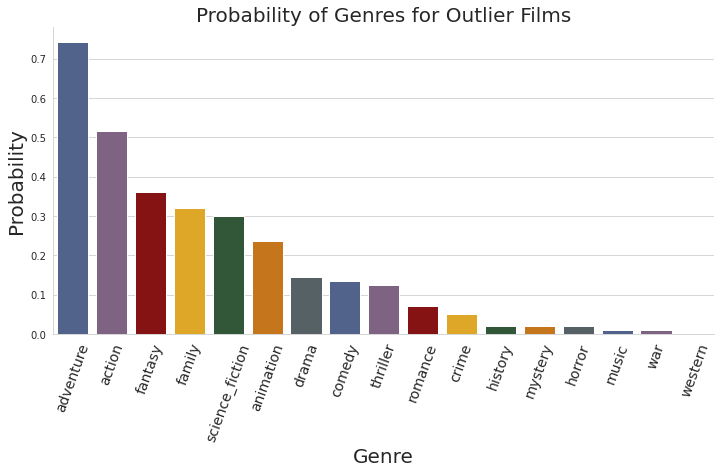

In [112]:
# plot probability distribution of movie genres for removed outlier films

sns.catplot(x='genre', y='mean', data=outlier_genres_mean_df, 
            kind='bar', palette=my_palette, 
            height=5, aspect=2).set_xticklabels(fontsize=14, rotation=70)

plt.xlabel('Genre', fontsize=20)
plt.ylabel('Probability', fontsize=20)

plt.title('Probability of Genres for Outlier Films', fontsize=20);

Action and adventure movies dominate the outliers, appearing in over half of the 97 removed films.

In [113]:
# get the counts of outlier movie genres
outlier_movies_df[genres_lst].sum(axis=0).sort_values(ascending=False)

adventure          72
action             50
fantasy            35
family             31
science_fiction    29
animation          23
drama              14
comedy             13
thriller           12
romance             7
crime               5
history             2
horror              2
mystery             2
war                 1
music               1
western             0
dtype: int64

I'll sort through some this data by observing genre combinations.

 > **Movie Focus (Crossover Genres)**

Now, I'll show how the genres appear in combinations with each other, when defining a movie.<br>
The first value will be the number of occurances for the genre being examined.<br>
The values below that one will count the number of times the first genre appeared with the one corresponding to that value.

In [114]:
# count movies where other genres combine with adventure for outlier films
outlier_movies_df[outlier_movies_df['adventure'] == 1][genres_lst].sum(
    axis=0).sort_values(ascending=False)

adventure          72
action             45
fantasy            31
science_fiction    28
family             20
animation          14
comedy             10
thriller            6
drama               1
history             1
horror              1
mystery             1
romance             1
war                 0
crime               0
music               0
western             0
dtype: int64

The adventure genre combines with many other film categories.

In [115]:
# count movies where other genres combine with action for outlier films
outlier_movies_df[outlier_movies_df['action'] == 1][genres_lst].sum(
    axis=0).sort_values(ascending=False)

action             50
adventure          45
science_fiction    26
fantasy            17
thriller            9
crime               3
family              2
animation           2
comedy              2
drama               2
western             0
war                 0
horror              0
music               0
mystery             0
romance             0
history             0
dtype: int64

All but 5 action films were adventure, as well.

In [116]:
# get the 5 outlier films in the action genre, but not considered adventure
outlier_movies_df[(
    outlier_movies_df['action'] == 1) & (
    outlier_movies_df['adventure'] == 0)][['title'] + genres_lst]

,title,action,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
425,The Dark Knight Rises,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
436,The Dark Knight,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
1027,Spider-Man,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2969,Furious 7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3069,The Fate of the Furious,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


These film were considered to be crime, drama, and thriller movies, rather than adventure films.

In [117]:
# count movies where other genres combine with science fiction for outlier films
outlier_movies_df[outlier_movies_df['science_fiction'] == 1][genres_lst].sum(
    axis=0).sort_values(ascending=False)

science_fiction    29
adventure          28
action             26
fantasy             4
thriller            2
family              1
drama               1
animation           0
comedy              0
crime               0
western             0
war                 0
horror              0
music               0
mystery             0
romance             0
history             0
dtype: int64

Only 1 science fiction film was not considered an adventure film.

In [118]:
# get the 1 outlier film in the science fiction genre, but not considered adventure
outlier_movies_df[(
    outlier_movies_df['adventure'] == 0) & (
    outlier_movies_df['science_fiction'] == 1)][['title'] + genres_lst]

,title,action,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
7409,Close Encounters of the Third Kind,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


Close Encounters was classified as a science fiction drama, not a science fiction adventure.<br>
I would agree with that labelling.

The science fiction movies were all in the action genre, except for 3 of them

In [119]:
# get the 3 outlier films in the science fiction genre, but not considered action
outlier_movies_df[(
    outlier_movies_df['action'] == 0) & (
    outlier_movies_df['science_fiction'] == 1)][['title'] + genres_lst]

,title,action,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
7004,E.T. the Extra-Terrestrial,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
7409,Close Encounters of the Third Kind,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
9925,Jurassic Park,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Here, the genre lines are blurred, as Jurassic Park is not in the action genre, as is the rest of the Jurassic Series.<br>
This can be observed, below.

In [120]:
# observe the Jurassic Park film series
actor_df[actor_df['title'].isin(
    set([title for title in actor_df['title'] if 'Jurassic' in title ]))][
    ['title'] + genres_lst].drop_duplicates()

,title,action,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
310,The Lost World: Jurassic Park,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5693,Jurassic Park III,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
6582,Jurassic World: Fallen Kingdom,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9925,Jurassic Park,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12759,Jurassic World,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [121]:
# count movies where other genres combine with fantasy for outlier films
outlier_movies_df[outlier_movies_df['fantasy'] == 1][genres_lst].sum(
    axis=0).sort_values(ascending=False)

fantasy            35
adventure          31
action             17
family             12
animation           5
science_fiction     4
comedy              4
romance             3
drama               1
mystery             1
crime               0
western             0
war                 0
horror              0
music               0
thriller            0
history             0
dtype: int64

4 fantasy movies were not adventure films, as well.

In [122]:
# get the 4 outlier films in the fantasy genre, but not considered adventure
outlier_movies_df[(
    outlier_movies_df['adventure'] == 0) & (
    outlier_movies_df['fantasy'] == 1)][['title'] + genres_lst]

,title,action,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
1027,Spider-Man,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6195,Beauty and the Beast,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
10746,Snow White and the Seven Dwarfs,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0
25989,Cinderella,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0


These films are in either the family or action genres, as opposed to being adventure movies.

In [123]:
# count movies where other genres combine with animation for outlier films
outlier_movies_df[outlier_movies_df['animation'] == 1][genres_lst].sum(
    axis=0).sort_values(ascending=False)

animation          23
family             23
adventure          14
comedy             10
fantasy             5
action              2
drama               2
romance             1
crime               0
western             0
war                 0
horror              0
music               0
mystery             0
science_fiction     0
thriller            0
history             0
dtype: int64

All of the animation movies removed from the dataset were family films.

As I just showed, many of the outlier films were classified by the same genre combinations.<br>
There be enough nuances in the films that were just outside the major genre combinations to be useful for modelling.<br>
It is difficult to say for sure at this point, though.

Now, I'll create a DataFrame of the actors who had their average revenues reduced or were eliminated from the dataset.

 > **Actor Focus (Data Bias)**

In [124]:
# extract actors who were in outlier movies, and aggregate over those films
actor_in_outlier_movie = actor_df[actor_df['movie_id'].isin(
    ids_outlier_movies)][actor_features + genres_lst + ['revenue']].groupby(
    'person_id').agg(
    {'name': 'first', 'age': np.mean, 'gender': 'first', 'revenue': np.mean, 
     'action': np.sum, 'adventure': np.sum, 'animation': np.sum, 'comedy': np.sum, 
     'crime': np.sum, 'drama': np.sum, 'family': np.sum, 'fantasy': np.sum, 
     'history': np.sum, 'horror': np.sum, 'music': np.sum, 'mystery': np.sum, 
     'romance': np.sum, 'science_fiction': np.sum, 'thriller': np.sum, 
     'war': np.sum, 'western': np.sum
    }).reset_index().rename(columns={'index': 'person_id'})

# change gender labels
actor_in_outlier_movie['gender'].replace([0, 1], ['male', 'female'], inplace=True)

actor_in_outlier_movie

,person_id,name,age,gender,revenue,action,adventure,animation,comedy,crime,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
0,2,Mark Hamill,47.442453,male,1.873119e+09,6,6,0,0,0,...,1,0,0,0,0,0,6,0,0,0
1,3,Harrison Ford,45.185870,male,1.975206e+09,5,5,0,0,0,...,1,0,0,0,0,0,4,0,0,0
2,4,Carrie Fisher,42.369111,female,1.873119e+09,6,6,0,0,0,...,1,0,0,0,0,0,6,0,0,0
3,5,Peter Cushing,63.998576,male,3.319102e+09,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,6,Anthony Daniels,47.162091,male,1.743019e+09,5,5,0,0,0,...,0,0,0,0,0,0,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,1537686,Naomi Ackie,27.124445,female,1.078371e+09,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
537,1545693,Zazie Beetz,28.337338,female,1.077361e+09,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
538,1559638,Hayden Rolence,11.920847,male,1.101534e+09,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
539,1639847,Yahya Abdul-Mateen II,31.480455,male,1.175018e+09,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


There are 541 acotrs in this dataset.

 > **Gender Analysis**

In [125]:
# get number of actors whose revenues were lowered, due to removal of movie outliers
print('Actors in Outlier Movies...\n\nMale:   {}\nFemale: {}'.format(
    actor_in_outlier_movie['gender'].value_counts()[0], 
    actor_in_outlier_movie['gender'].value_counts()[1]))

Actors in Outlier Movies...

Male:   378
Female: 163


In [126]:
# get percent of male actors in full dataset
np.round(
    (df['gender'].value_counts() / df.shape[0])[0] * 100, decimals=2)

60.81

In [127]:
# get percent of male actors in optimized dataset
np.round(
    (no_movies_df['gender'].value_counts() / no_movies_df.shape[0])[0] * 100, decimals=2)

60.84

Even though more male actors were in outlier films, a greater percentage of female actors were removed from the data.<br>
This means that there was a larger proportion of female actors who were only in outlier movies.

In [128]:
# get percent of male actors in outlier movies
np.round(
    (actor_in_outlier_movie['gender'].value_counts() / 
     actor_in_outlier_movie.shape[0])[0] * 100, decimals=2)

69.87

Male actors comprise 9% more of the actors in outlier movies by gender than they did in the full dataset.

I will observe the various distributions of revenues by gender.

In [129]:
def get_average_revenues_by_gender():
    """Return DataFrame of revenues by gender"""
    # create copy of outlier DataFrame and alter labels to match other DataFrames
    copy_df = actor_in_outlier_movie.copy()
    copy_df['gender'].replace(['male', 'female'], [0, 1], inplace=True)
    # create lists and default dictionary to hold data
    data_lst = [df, no_movies_df, copy_df]
    genders_lst = [0, 1]
    revenue_dict = defaultdict(list)
    # loop through DataFrames
    for gender in genders_lst:
        for data in data_lst:
            # get average revenue by gender
            revenue_val = np.mean(data[data['gender'] == gender]['revenue'])
            # save results to default dictionary
            revenue_dict[gender].append(revenue_val)
            # collect sum of revenues for outlier movies            
            if data is copy_df:
                revenue_sum = np.sum(data[data['gender'] == gender]['revenue'])
                # save results to default dictionary
                revenue_dict[gender].append(revenue_sum)
        # get percent change in revenues
        revenue_change = (revenue_dict[gender][0] - 
                          revenue_dict[gender][1]) / revenue_dict[gender][0] * 100
        # save results to default dictionary
        revenue_dict[gender].append(revenue_change)
    # convert default dictionary to DataFrame
    revenues_df = pd.DataFrame(
        revenue_dict).rename(
        index={0: 'full_dataset_ave', 1: 'optimized_dataset_ave', 
               2: 'outlier_dataset_ave', 3: 'outlier_dataset_sum', 
               4: 'percent_revenue_change'}).rename(
        columns={0: 'male', 1: 'female'})
    
    return revenues_df.T

In [130]:
# get revenues by gender for full, optimized, and outlier movies datasets
get_average_revenues_by_gender().round(2)

,full_dataset_ave,optimized_dataset_ave,outlier_dataset_ave,outlier_dataset_sum,percent_revenue_change
male,1.427219e+08,1.161817e+08,1.589108e+09,6.006826e+11,18.60
female,1.323689e+08,1.042052e+08,1.775675e+09,2.894350e+11,21.28


The reduction of average revenue was of a greater proportion for the female actors.<br>
Since there were more male actors in the outlier movies, the total reduction in aveage revenue was greater for them.

Now, I'll observe the gender imbalance in the 6 most common genres from the outlier movies.

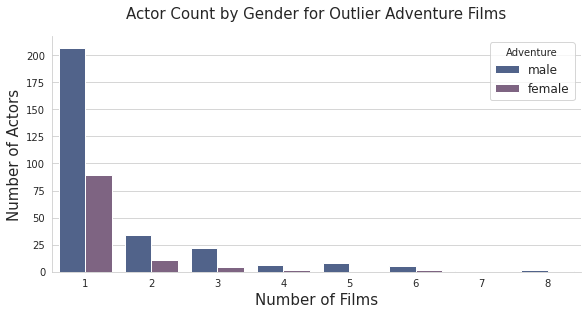

In [131]:
# plot number of actors in outlier adventure movies by gender & number of appearances

sns.catplot(x='adventure', hue='gender', 
            data=actor_in_outlier_movie[actor_in_outlier_movie['adventure'] > 0], 
            kind='count', legend_out=False, height=4, aspect=2)

plt.xlabel('Number of Films', fontsize=15)
plt.ylabel('Number of Actors', fontsize=15)

plt.legend(fontsize='large', title='Adventure', loc=1)

plt.title('Actor Count by Gender for Outlier Adventure Films', fontsize=15, y=1.05);

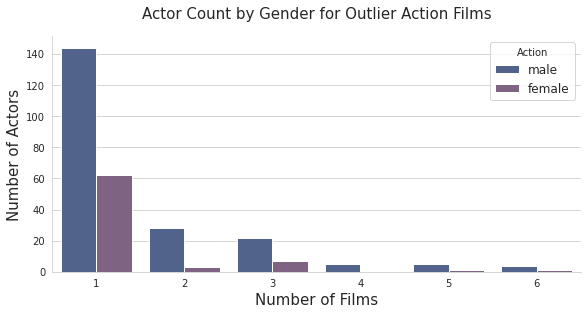

In [132]:
# plot number of actors in outlier action movies by gender & number of appearances

sns.catplot(x='action', hue='gender', 
            data=actor_in_outlier_movie[actor_in_outlier_movie['action'] > 0], 
            kind='count', legend_out=False, height=4, aspect=2)

plt.xlabel('Number of Films', fontsize=15)
plt.ylabel('Number of Actors', fontsize=15)

plt.legend(fontsize='large', title='Action', loc=1)

plt.title('Actor Count by Gender for Outlier Action Films', fontsize=15, y=1.05);

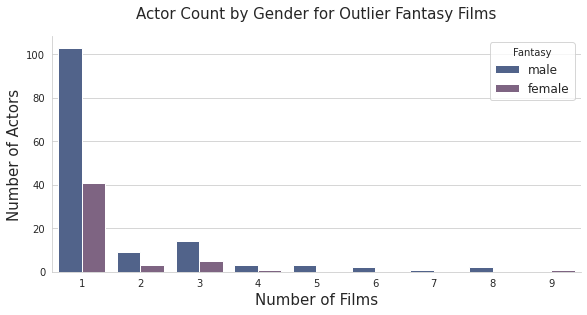

In [133]:
# plot number of actors in outlier fantasy movies by gender & number of appearances

sns.catplot(x='fantasy', hue='gender', 
            data=actor_in_outlier_movie[actor_in_outlier_movie['fantasy'] > 0], 
            kind='count', legend_out=False, height=4, aspect=2)

plt.xlabel('Number of Films', fontsize=15)
plt.ylabel('Number of Actors', fontsize=15)

plt.legend(fontsize='large', title='Fantasy', loc=1)

plt.title('Actor Count by Gender for Outlier Fantasy Films', fontsize=15, y=1.05);

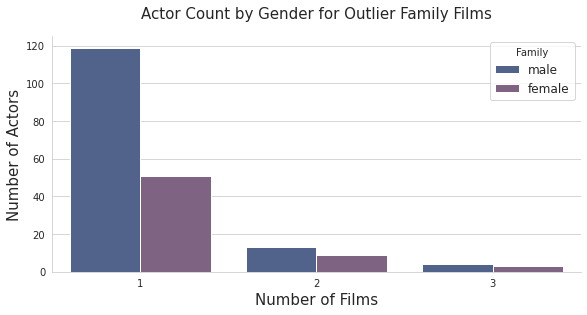

In [134]:
# plot number of actors in outlier family movies by gender & number of appearances

sns.catplot(x='family', hue='gender', 
            data=actor_in_outlier_movie[actor_in_outlier_movie['family'] > 0], 
            kind='count', legend_out=False, height=4, aspect=2)

plt.xlabel('Number of Films', fontsize=15)
plt.ylabel('Number of Actors', fontsize=15)

plt.legend(fontsize='large', title='Family', loc=1)

plt.title('Actor Count by Gender for Outlier Family Films', fontsize=15, y=1.05);

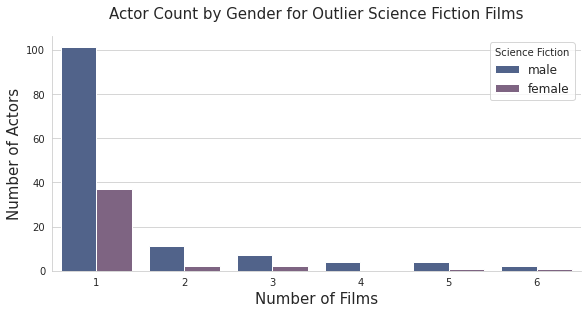

In [135]:
# plot number of actors in outlier science fiction movies by gender & number of appearances

sns.catplot(x='science_fiction', hue='gender', 
            data=actor_in_outlier_movie[actor_in_outlier_movie['science_fiction'] > 0], 
            kind='count', legend_out=False, height=4, aspect=2)

plt.xlabel('Number of Films', fontsize=15)
plt.ylabel('Number of Actors', fontsize=15)

plt.legend(fontsize='large', title='Science Fiction', loc=1)

plt.title('Actor Count by Gender for Outlier Science Fiction Films', fontsize=15, y=1.05);

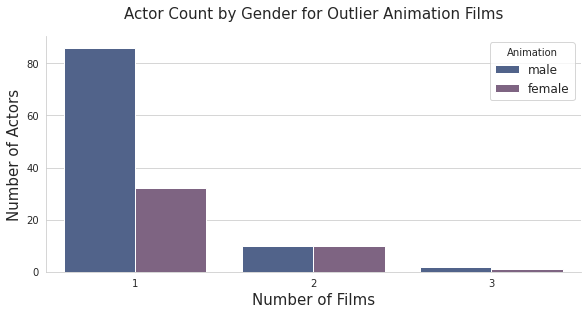

In [136]:
# plot number of actors in outlier animation movies by gender & number of appearances

sns.catplot(x='animation', hue='gender', 
            data=actor_in_outlier_movie[actor_in_outlier_movie['animation'] > 0], 
            kind='count', legend_out=False, height=4, aspect=2)

plt.xlabel('Number of Films', fontsize=15)
plt.ylabel('Number of Actors', fontsize=15)

plt.legend(fontsize='large', title='Animation')

plt.title('Actor Count by Gender for Outlier Animation Films', fontsize=15, y=1.05);

All of these movies were more comprised of male actors by at least a 2:1 ratio.<br>
After removing these movies, the gender bias in these genres with repsect to the aveage revenue values will be reduced.

Below, I will show this effect, across all of the genres.

In [137]:
# combine genres into feature and sum over all actors
age_gender_df = pd.melt(actor_in_outlier_movie, 
                        id_vars=['person_id', 'name', 'gender', 'age'], 
                        value_vars = genres_lst, 
                        var_name = 'genre', 
                        value_name = 'count')

# round off the ages to assist with plotting
age_gender_df['age'] = age_gender_df['age'].apply(np.round)

age_gender_df.head()

,person_id,name,gender,age,genre,count
0,2,Mark Hamill,male,47.0,action,6
1,3,Harrison Ford,male,45.0,action,5
2,4,Carrie Fisher,female,42.0,action,6
3,5,Peter Cushing,male,64.0,action,1
4,6,Anthony Daniels,male,47.0,action,5


In [138]:
# drop observations without genre
age_gender_df = age_gender_df.loc[age_gender_df['count'] > 0]

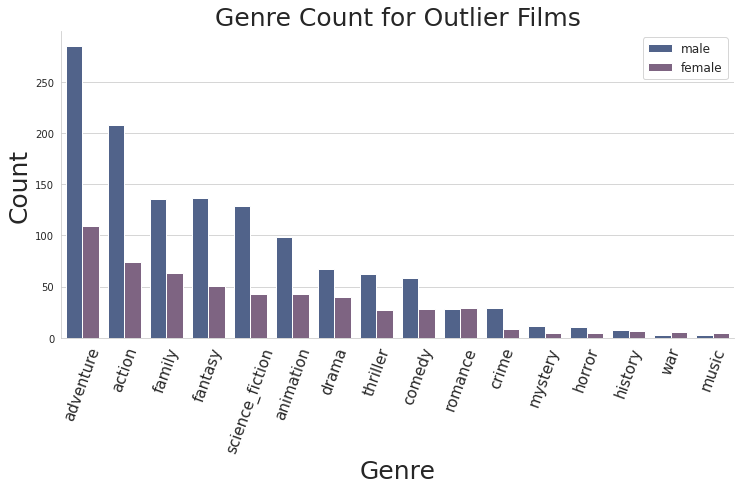

In [139]:
# plot count of movie genres for removed outlier films

# determine descending order of plot
genres_descending_lst = age_gender_df['genre'].value_counts().index.tolist()

sns.catplot(x='genre', hue='gender', data=age_gender_df, order=genres_descending_lst, 
                    kind='count', height=5, aspect=2, legend_out=False, 
                    palette=my_palette).set_xticklabels(fontsize=15, rotation=70)

plt.xlabel('Genre', fontsize=25)
plt.ylabel('Count', fontsize=25)

plt.legend(fontsize='large')

plt.title('Genre Count for Outlier Films', fontsize=25);

The genres are ordered, going from left to right, by a decreasing number of actors in each group.<br>
The outlier movies had significantly more male actors than female actors for most of the genres. 

 > **Age Analysis**

In [140]:
# get number of actors whose revenues were lowered, due to removal of movie outliers
print('Actors in Outlier Movies...\n\nYoung: {}\nOld:   {}'.format(
    actor_in_outlier_movie[actor_in_outlier_movie['age'] < np.mean(df['age'])].shape[0], 
    actor_in_outlier_movie[actor_in_outlier_movie['age'] >= np.mean(df['age'])].shape[0]))

Actors in Outlier Movies...

Young: 220
Old:   321


In [141]:
# get average age of actors in full dataset
np.round(np.mean(df['age']), decimals=3)

37.861

In [142]:
# get average age of actors in optimized dataset
np.round(np.mean(no_movies_df['age']), decimals=3)

37.859

In [143]:
# get average age of actors in outlier films
np.round(np.mean(actor_in_outlier_movie['age']), decimals=3)

42.311

The actors in the outlier movies are 5 years older, on average, than those in the original dataset.<br>
More actors above the average age of all actors were removed.

I will observe the various distributions of revenues by age.

In [144]:
def get_average_revenues_by_age():
    """Return DataFrame of actor revenues by age"""
    # create list and default dictionary to hold data
    data_lst = [df, no_movies_df, actor_in_outlier_movie]
    revenue_dict = defaultdict(list)
    # loop through DataFrames
    for data in data_lst:
        mean_age = np.mean(data['age'])
        revenue_young = np.mean(data[data['age'] < mean_age]['revenue'])
        revenue_old = np.mean(data[data['age'] >= mean_age]['revenue'])
        # save results to default dictionary
        revenue_dict['young'].append(revenue_young)
        revenue_dict['old'].append(revenue_old)
        # collect sums of revenues for outlier movies
        if data is actor_in_outlier_movie:
            revenue_young_sum = np.sum(data[data['age'] < mean_age]['revenue'])
            revenue_old_sum = np.sum(data[data['age'] >= mean_age]['revenue'])
            revenue_dict['young'].append(revenue_young_sum)
            revenue_dict['old'].append(revenue_old_sum)
    # get percent change in revenues
    revenue_change_young = (revenue_dict['young'][0] - 
                            revenue_dict['young'][1]) / revenue_dict['young'][0] * 100        
    revenue_change_old = (revenue_dict['old'][0] - 
                          revenue_dict['old'][1]) / revenue_dict['old'][0] * 100
    # save results to default dictionary
    revenue_dict['young'].append(revenue_change_young)
    revenue_dict['old'].append(revenue_change_old)
    # convert default dictionary to DataFrame
    revenues_df = pd.DataFrame(
        revenue_dict).rename(
        index={0: 'full_dataset_ave', 1: 'optimized_dataset_ave', 
               2: 'outlier_dataset_ave', 3: 'outlier_dataset_sum', 
               4: 'percent_revenue_change'}).rename(
        columns={0: 'young', 1: 'old'})

    return revenues_df.T

In [145]:
# get revenues by age for full, optimized, and outlier movies datasets
get_average_revenues_by_age().round(2)

,full_dataset_ave,optimized_dataset_ave,outlier_dataset_ave,outlier_dataset_sum,percent_revenue_change
young,1.292683e+08,1.040319e+08,1.690844e+09,4.531463e+11,19.52
old,1.498385e+08,1.203688e+08,1.600628e+09,4.369714e+11,19.67


The proportional average revenue reduction was similar for both age groups.<br>
The difference between the decline in total average revenues was not as stark as it was when observing the genders.

I'll observe the average age of actors who were in the outlier movies by genre.

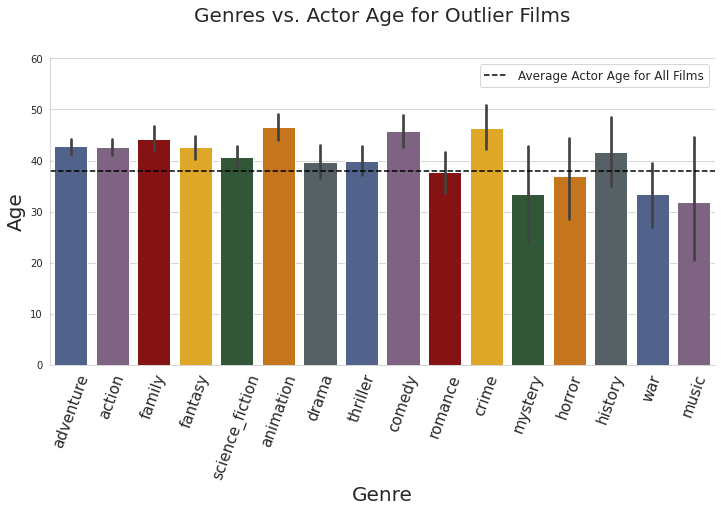

In [146]:
# plot age distribution of movie genres for removed outlier films

sns.catplot(x='genre', y='age',data=age_gender_df, order=genres_descending_lst, 
            kind='bar', height=5, aspect=2, legend_out=False, 
            palette=my_palette).set_xticklabels(
            fontsize=15, rotation=70).axes[0][0].axhline(
            np.mean(df['age']), ls='--', color='k')

plt.ylim(0, 60)
plt.xlabel('Genre', fontsize=20)
plt.ylabel('Age', fontsize=20)

plt.legend([Line2D([0], [0], color='k', linestyle='--')], 
           ['Average Actor Age for All Films'], fontsize='large', loc=1)
plt.title('Genres vs. Actor Age for Outlier Films', fontsize=20, y=1.1);

The genre groups are ordered the same as the previous plot.<br>
The most represented genres of removed movies had actors older than the average actor age for all movies.